In [1]:
import os
import urllib.request
from io import BytesIO
import requests
import json

import torch

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import h5py

import open3d as o3d

import matplotlib.image as mpimg
import re
from csv import writer
import pymeshlab

from utils.preprocessing import *
from models.model_data import *
from models_3d import point_clouds
from models import controlnet_model_wrapper



WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.13.1+cu117 with CUDA 1107 (you have 1.12.1+cpu)
    Python  3.8.10 (you have 3.8.16)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
C:\Users\User\anaconda3\envs\stable_diff\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\User\anaconda3\envs\stable_diff\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
nyu_path = 'C:/Users/User/Documents/Data_Science/ar_stable_diffusion/data/nyu_depth_v2_labeled.mat'
nyu_result_root = './results/NYU/'
eval_results_path = nyu_result_root + "eval_logs.csv"

save_folder = nyu_result_root

guidance_scale = 7.5
strength=0.5
num_inference_steps=20

# read mat file
f = h5py.File(nyu_path)

rgb_images = f['images']
depth_maps = f['depths']

"""
Nx4 matrix of accelerometer values indicated when each frame was taken. 
The columns contain the roll, yaw, pitch and tilt angle of the device.
"""
accel_data = f['accelData']

seg_mask = f['labels']

"""Cx1 cell array of the english names of each class."""
names = f['names']

""" map from english label names to class IDs (with C key-value pairs)"""
namesToIds = f['namesToIds']

"""Nx1 cell array of the name of the scene from which each image was taken."""
scenes = f['scenes']




C:\Users\User\AppData\Local\Temp\ipykernel_36860\393417447.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(nyu_path)


In [3]:
f[scenes[0][0]].attrs.keys()

<KeysViewHDF5 ['MATLAB_class', 'MATLAB_int_decode']>

In [6]:
#point_clouds.rebuild_point_clouds(rgb_image=rgb_images[i], depth_map=depth_maps[i],i=i, display=True, condition_type = "seg")

(PointCloud with 360448 points., PointCloud with 360448 points.)

In [8]:
#pcd = o3d.io.read_point_cloud( nyu_result_root + f"point_clouds/{i}_ground_pcd_from_seg.pcd")
#o3d.visualization.draw_geometries([pcd])

In [5]:
#pcd = o3d.io.read_point_cloud( nyu_result_root + f"point_clouds/{i}_gen_pcd_from_seg.pcd")
#o3d.visualization.draw_geometries([pcd])

In [6]:
i = 0

In [6]:
i = 5
original_pcd, generated_pcd = point_clouds.rebuild_point_clouds(rgb_images[i], depth_maps[i], i=i, result_root='./results/NYU/', display=True, condition_type="seg")
    

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


## Using Acceleration Data

In [8]:
roll = accel_data[0]
yaw = accel_data[1]
pitch = accel_data[2]
tilt = accel_data[3]


In [9]:
accel_data

<HDF5 dataset "accelData": shape (4, 1449), type "<f4">

In [10]:
import math

def rotation_matrix(pitch,roll,yaw):
    #taken from: https://www.zacobria.com/universal-robots-knowledge-base-tech-support-forum-hints-tips-cb2-cb3/index.php/python-code-example-of-converting-rpyeuler-angles-to-rotation-vectorangle-axis-for-universal-robots/
   
    yawMatrix = np.matrix([
    [math.cos(yaw), -math.sin(yaw), 0],
    [math.sin(yaw), math.cos(yaw), 0],
    [0, 0, 1]
    ])

    pitchMatrix = np.matrix([
    [math.cos(pitch), 0, math.sin(pitch)],
    [0, 1, 0],
    [-math.sin(pitch), 0, math.cos(pitch)]
    ])

    rollMatrix = np.matrix([
    [1, 0, 0],
    [0, math.cos(roll), -math.sin(roll)],
    [0, math.sin(roll), math.cos(roll)]
    ])

    R = yawMatrix * pitchMatrix * rollMatrix
    
    return R

In [47]:
R0 = rotation_matrix(pitch[0],roll[0],yaw[0])
R1 = rotation_matrix(pitch[1],roll[1],yaw[1])
R2 = rotation_matrix(pitch[2],roll[2],yaw[2])



rotated_original_pcd = original_pcd.rotate((R0))
rotated_original_pcd_2 = original_pcd_2.rotate((R1))
rotated_original_pcd_3 = original_pcd_3.rotate((R2))

# Merging Point Clouds 

## Merging without any optimization or transformation

## Images 5,6,7

In [20]:
def load_point_clouds(voxel_size=0.01, pcd_range=[5,8]):
    pcds_orig= []
    pcds_gen = []
    for i in range(pcd_range[0],pcd_range[1]):
        original_pcd_i, generated_pcd_i = point_clouds.rebuild_point_clouds(rgb_images[i], depth_maps[i], i=i, result_root='./results/NYU/', display=False, condition_type="seg")
        pcd_down = original_pcd_i.voxel_down_sample(voxel_size=voxel_size)
        pcds_orig.append(pcd_down)
        
        pcd_down = generated_pcd_i.voxel_down_sample(voxel_size=voxel_size)
        pcds_gen.append(pcd_down)
    return pcds_orig, pcds_gen

In [12]:
voxel_size=0.001
pcds_orig, pcds_gen = load_point_clouds(voxel_size=voxel_size)
    
#pcds= [rotated_original_pcd, rotated_original_pcd_2, rotated_original_pcd_3]
#pcds_down = [pcd.voxel_down_sample(voxel_size=voxel_size) for pcd in [original_pcd, original_pcd_2, original_pcd_3]]

#o3d.visualization.draw_geometries(pcds)

In [14]:
o3d.visualization.draw_geometries(pcds_orig)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [15]:
o3d.visualization.draw_geometries(pcds_gen)

KeyboardInterrupt: 

In [16]:


def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [17]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_orig,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 0.3760, RMSE 0.0081
[Open3D DEBUG] Residual : 4.16e-05 (# of elements : 101251)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.3834, RMSE 0.0079
[Open3D DEBUG] Residual : 4.02e-05 (# of elements : 103264)
[Open3D DEBUG] ICP Iteration #2: Fitness 0.3884, RMSE 0.0077
[Open3D DEBUG] Residual : 3.86e-05 (# of elements : 104613)
[Open3D DEBUG] ICP Iteration #3: Fitness 0.3922, RMSE 0.0076
[Open3D DEBUG] Residual : 3.76e-05 (# of elements : 105624)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.3953, RMSE 0.0076
[Open3D DEBUG] Residual : 3.70e-05 (# of elements : 106471)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.3984, RMSE 0.0076
[Open3D DEBUG] Residual : 3.68e-05 (# of elements : 107308)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.4017, RMSE 0.0076
[Open3D DEBUG] Residual : 3.66e-05 (# of elements : 108193)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.4042, RMSE 0.0077
[Open3D DEBUG] Residual : 3.66e-05 (# of elem

[Open3D DEBUG] ICP Iteration #10: Fitness 0.0953, RMSE 0.0085
[Open3D DEBUG] Residual : 4.87e-05 (# of elements : 25664)
[Open3D DEBUG] ICP Iteration #11: Fitness 0.0956, RMSE 0.0085
[Open3D DEBUG] Residual : 4.87e-05 (# of elements : 25747)
[Open3D DEBUG] ICP Iteration #12: Fitness 0.0960, RMSE 0.0085
[Open3D DEBUG] Residual : 4.86e-05 (# of elements : 25859)
[Open3D DEBUG] ICP Iteration #13: Fitness 0.0964, RMSE 0.0085
[Open3D DEBUG] Residual : 4.82e-05 (# of elements : 25960)
[Open3D DEBUG] ICP Iteration #14: Fitness 0.0969, RMSE 0.0085
[Open3D DEBUG] Residual : 4.84e-05 (# of elements : 26085)
[Open3D DEBUG] ICP Iteration #15: Fitness 0.0973, RMSE 0.0085
[Open3D DEBUG] Residual : 4.88e-05 (# of elements : 26191)
[Open3D DEBUG] ICP Iteration #16: Fitness 0.0976, RMSE 0.0085
[Open3D DEBUG] Residual : 4.89e-05 (# of elements : 26278)
[Open3D DEBUG] ICP Iteration #17: Fitness 0.0978, RMSE 0.0085
[Open3D DEBUG] Residual : 4.88e-05 (# of elements : 26328)
[Open3D DEBUG] ICP Iteration #18

[Open3D DEBUG] ICP Iteration #3: Fitness 0.0060, RMSE 0.0010
[Open3D DEBUG] Residual : 4.40e-07 (# of elements : 1748)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.43e-07 (# of elements : 1771)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.44e-07 (# of elements : 1772)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.49e-07 (# of elements : 1777)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.48e-07 (# of elements : 1781)
[Open3D DEBUG] ICP Iteration #8: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.49e-07 (# of elements : 1778)
[Open3D DEBUG] ICP Iteration #9: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.53e-07 (# of elements : 1781)
[Open3D DEBUG] ICP Iteration #10: Fitness 0.0061, RMSE 0.0010
[Open3D DEBUG] Residual : 4.59e-07 (# of elements : 1782)
[Open3D DEBUG] ICP Iteration #11: Fitness 0.006

In [18]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 3 nodes and 3 edges.
[Open3D DEBUG] Line process weight : 0.012880
[Open3D DEBUG] [Initial     ] residual : 1.919549e+01, lambda : 1.562100e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] [GlobalOptimizationLM] total time : 0.001 sec.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 3 nodes and 2 edges.
[Open3D DEBUG] Line process weight : 0.017574
[Open3D DEBUG] [Initial     ] residual : 1.688562e-11, lambda : 1.562100e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] [GlobalOptimizationLM] total time : 0.000 sec.
[Open3D DEBUG] CompensateReferencePoseGraphNode : reference : 0


In [19]:
print("Transform points and display")
for point_id in range(len(pcds_orig)):
    print(pose_graph.nodes[point_id].pose)
    pcds_orig[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_orig)

Transform points and display
[[ 1.00000000e+00  6.87094072e-26  2.06795153e-25  1.03397577e-25]
 [ 6.87095524e-26  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.06795153e-25  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99980545  0.01450927  0.01336176  0.00675335]
 [-0.01515285  0.99866433  0.04939573  0.02116762]
 [-0.01262722 -0.04958859  0.9986899   0.04096849]
 [ 0.          0.          0.          1.        ]]
[[ 0.89617027 -0.37467931 -0.2376852  -0.13754362]
 [ 0.34585059  0.92542889 -0.15481843 -0.01700631]
 [ 0.27796801  0.05654011  0.95892492  0.07660928]
 [ 0.          0.          0.          1.        ]]


## Images 14,15

In [21]:
voxel_size=0.001
pcds_orig_2, pcds_gen_2 = load_point_clouds(voxel_size=voxel_size, pcd_range=[14,16])

In [22]:
o3d.visualization.draw_geometries(pcds_orig_2)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [23]:
o3d.visualization.draw_geometries(pcds_gen_2)

In [33]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_orig_2,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 0.1673, RMSE 0.0099
[Open3D DEBUG] Residual : 7.62e-05 (# of elements : 35143)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.2470, RMSE 0.0089
[Open3D DEBUG] Residual : 6.30e-05 (# of elements : 51876)
[Open3D DEBUG] ICP Iteration #2: Fitness 0.2875, RMSE 0.0078
[Open3D DEBUG] Residual : 4.71e-05 (# of elements : 60383)
[Open3D DEBUG] ICP Iteration #3: Fitness 0.3002, RMSE 0.0074
[Open3D DEBUG] Residual : 4.15e-05 (# of elements : 63068)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.3058, RMSE 0.0073
[Open3D DEBUG] Residual : 3.88e-05 (# of elements : 64225)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.3073, RMSE 0.0072
[Open3D DEBUG] Residual : 3.77e-05 (# of elements : 64551)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.3080, RMSE 0.0071
[Open3D DEBUG] Residual : 3.74e-05 (# of elements : 64697)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.3082, RMSE 0.0071
[Open3D DEBUG] Residual : 3.73e-05 (# of elements : 

In [35]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 0.034038
[Open3D DEBUG] [Initial     ] residual : 1.159935e-30, lambda : 1.512800e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 0.034038
[Open3D DEBUG] [Initial     ] residual : 1.159935e-30, lambda : 1.512800e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] CompensateReferencePoseGraphNode : reference : 0


In [36]:
print("Transform points and display")
for point_id in range(len(pcds_orig_2)):
    print(pose_graph.nodes[point_id].pose)
    pcds_orig_2[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_orig_2)

Transform points and display
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 9.97889224e-01  3.98527815e-02  5.12723351e-02  3.80827335e-02]
 [-3.84167101e-02  9.98849683e-01 -2.86961200e-02 -7.25245784e-04]
 [-5.23569759e-02  2.66658345e-02  9.98272348e-01 -2.65986515e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


-------------------

In [27]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_gen_2,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 0.1427, RMSE 0.0089
[Open3D DEBUG] Residual : 7.22e-05 (# of elements : 24531)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.2045, RMSE 0.0089
[Open3D DEBUG] Residual : 7.50e-05 (# of elements : 35151)
[Open3D DEBUG] ICP Iteration #2: Fitness 0.2405, RMSE 0.0081
[Open3D DEBUG] Residual : 6.13e-05 (# of elements : 41335)
[Open3D DEBUG] ICP Iteration #3: Fitness 0.2593, RMSE 0.0081
[Open3D DEBUG] Residual : 6.13e-05 (# of elements : 44572)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.2722, RMSE 0.0083
[Open3D DEBUG] Residual : 6.37e-05 (# of elements : 46787)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.2796, RMSE 0.0084
[Open3D DEBUG] Residual : 6.43e-05 (# of elements : 48062)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.2830, RMSE 0.0082
[Open3D DEBUG] Residual : 6.10e-05 (# of elements : 48645)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.2844, RMSE 0.0079
[Open3D DEBUG] Residual : 5.58e-05 (# of elements : 

In [32]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 0.034038
[Open3D DEBUG] [Initial     ] residual : 9.170224e-31, lambda : 1.512800e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 0.034038
[Open3D DEBUG] [Initial     ] residual : 9.170224e-31, lambda : 1.512800e-01
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] CompensateReferencePoseGraphNode : reference : 0


In [30]:
print("Transform points and display")
for point_id in range(len(pcds_gen_2)):
    print(pose_graph.nodes[point_id].pose)
    pcds_gen_2[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_gen_2)

Transform points and display
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.98960737 -0.12108406 -0.07756221  0.00864667]
 [ 0.12722623  0.98865391  0.07985574  0.0133932 ]
 [ 0.06701293 -0.08889378  0.99378426 -0.06073569]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [37]:
o3d.visualization.draw_geometries(pcds_gen_2)

In [ ]:

o3d.visualization.draw_geometries(pcds_orig_2)

In [9]:
radius

0.0013758556645133396

In [3]:
result_root = 'C:/Users/User/Documents/Data_Science/ar_stable_diffusion/server/user_data'


In [4]:
pcd_path = result_root + "/ground_point_clouds/0_arcore_ground_pcd.pcd"
pcd = o3d.io.read_point_cloud( pcd_path )

In [5]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)

pcd_small = pcd.voxel_down_sample(voxel_size=0.0007)

In [6]:
pcd_small.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([pcd_small],point_show_normal=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [8]:
radius = 5 * avg_dist

bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_small, o3d.utility.DoubleVector([radius, radius * 2]))

bpa_mesh.remove_degenerate_triangles()
bpa_mesh.remove_duplicated_triangles()
bpa_mesh.remove_duplicated_vertices()
bpa_mesh.remove_non_manifold_edges()



o3d.visualization.draw_geometries([bpa_mesh], mesh_show_back_face=True)

In [10]:



    radii = [0.001, 0.005, 0.01, 0.02]
    bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii))

    bpa_mesh.remove_degenerate_triangles()
    bpa_mesh.remove_duplicated_triangles()
    bpa_mesh.remove_duplicated_vertices()
    bpa_mesh.remove_non_manifold_edges()
    
    o3d.visualization.draw_geometries([bpa_mesh], mesh_show_back_face=True)

AttributeError: module 'open3d.visualization' has no attribute 'draw'

In [13]:

    
    o3d.visualization.draw_geometries([bpa_mesh], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [15]:
import jsonify

ModuleNotFoundError: No module named 'jsonify'

In [2]:
import open3d as o3d
mesh = o3d.io.read_triangle_mesh("server/user_data/processed_user_data/157115077367582_mesh.obj")

In [3]:
import io

In [4]:
        buf = io.BytesIO()

        buf.read(mesh)

TypeError: argument should be integer or None, not 'open3d.cpu.pybind.geometry.TriangleMesh'

In [9]:
mesh = o3d.io.read_triangle_mesh('C:\\Users\\User\\Documents\\Data_Science\\ar_stable_diffusion\\server\\user_data\\processed_user_data\\36292670820492_mesh.obj')

In [10]:
o3d.visualization.draw_geometries([mesh])

In [5]:
o3d.io.write_triangle_mesh("server/user_data/processed_user_data/187389569134163_mesh.fbx",mesh,  write_triangle_uvs=True)

[Open3D WARNING] Write geometry::TriangleMesh failed: unknown file extension.


False

In [14]:
print(mesh.vertex_colors)

std::vector<Eigen::Vector3d> with 66005 elements.
Use numpy.asarray() to access data.


In [15]:
path = 'C:\\Users\\User\\Documents\\Data_Science\\ar_stable_diffusion\\server\\user_data\\processed_user_data\\36707154868244_mesh.obj'

mesh = o3d.io.read_triangle_mesh(path)
o3d.visualization.draw_geometries([mesh])

In [23]:
ms = pymeshlab.MeshSet()
ms.load_new_mesh( path )
ms.compute_color_transfer_vertex_to_face()
ms.compute_texcoord_parametrization_triangle_trivial_per_wedge(textdim=4000)
ms.compute_texmap_from_color(textname="new.mtl", textw=4000, texth=4000)

In [24]:
 
    ms.save_current_mesh("server/user_data/187389569134163_mesh.obj")

In [7]:
        original_pcd = o3d.io.read_point_cloud("187389569134163_arcore_ground_pcd.pcd")
        o3d.visualization.draw_geometries([original_pcd])
        small_pcd = original_pcd.voxel_down_sample(voxel_size=0.0007)
        o3d.visualization.draw_geometries([small_pcd])

        radii = [0.001, 0.005, 0.01]
        bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            small_pcd, o3d.utility.DoubleVector(radii))

        bpa_mesh = bpa_mesh.simplify_quadric_decimation(100000)
        bpa_mesh.remove_degenerate_triangles()
        bpa_mesh.remove_duplicated_triangles()
        bpa_mesh.remove_duplicated_vertices()
        bpa_mesh.remove_non_manifold_edges()
        bpa_mesh.scale(10, center=bpa_mesh.get_center())
        
        o3d.visualization.draw_geometries([bpa_mesh])

        o3d.io.write_triangle_mesh("test_mesh.obj", bpa_mesh)

        ms = pymeshlab.MeshSet()
        ms.load_new_mesh(full_mesh_path)
        ms.compute_texmap_from_color()
        ms.save_current_mesh("test_mesh.obj")


[Open3D WARNING] Read PCD failed: unable to open file: 187389569134163_arcore_ground_pcd.pcd
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


RuntimeError: [Open3D ERROR] ReconstructBallPivoting requires normals

In [ ]:
import numpy as np
import cv2
import os, sys, io
import matplotlib.pyplot as plt
from utils.preprocessing import *
from models.controlnet_model_wrapper import ControlNetModelWrapper
from models_3d import point_clouds
import pymeshlab

def process_arcore_ground(self, rgb_filepath, depth_filepath, i=0, resolution=512):
        predict_ground_depth_path = os.path.join(self.data_root, "ControlNet", "predicted_ground_truth_depth_maps",
                                                 f"{i}_predict_ground_depth")

        ground_pcd_path = os.path.join(self.data_root, "ground_point_clouds", f"{i}_arcore_ground_pcd")

        rgb_image, depth_map = prepare_arcore_data(rgb_filepath, depth_filepath, image_resolution=resolution)

        predict_ground_depth_map = self.model.infer_depth_map(rgb_image, save_name=predict_ground_depth_path,
                                                              display=False)

        predict_ground_depth_map = resize_image(predict_ground_depth_map, resolution=resolution)
        predict_ground_depth_map_aligned = align_midas_withzeros(predict_ground_depth_map, depth_map)

        original_pcd = point_clouds.get_point_cloud(rgb_image, predict_ground_depth_map_aligned,
                                                    pcd_path=ground_pcd_path + ".pcd",
                                                    display=False)
        small_pcd = original_pcd.voxel_down_sample(voxel_size=0.0005)

        radii = [0.001, 0.005, 0.01]
        bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            small_pcd, o3d.utility.DoubleVector(radii))

        bpa_mesh = bpa_mesh.simplify_quadric_decimation(100000)
        bpa_mesh.remove_degenerate_triangles()
        bpa_mesh.remove_duplicated_triangles()
        bpa_mesh.remove_duplicated_vertices()
        bpa_mesh.remove_non_manifold_edges()
        bpa_mesh.scale(10, center=bpa_mesh.get_center())


        relative_mesh_path = os.path.join("processed_user_data", f"{i}_mesh.obj")
        relative_material_path = os.path.join("processed_user_data", f"{i}_mesh.mtl")

        full_mesh_path = os.path.join(self.data_root, relative_mesh_path)

        o3d.io.write_triangle_mesh(full_mesh_path, bpa_mesh)

        ms = pymeshlab.MeshSet()
        ms.load_new_mesh(full_mesh_path)
        ms.compute_texmap_from_color()
        ms.save_current_mesh(full_mesh_path)

In [ ]:

handler = ARCoreHandler(data_root=UPLOAD_FOLDER)


"server/user_data/3311_depthImage_depthImage.txt"
"server/user_data/3311_depthImage_rgbImage.txt"

In [6]:
depth_filepath="server/user_data/3311_depthImage.txt"
rgb_filepath ="server/user_data/3311_rgbImage.jpg"

#rgb_image, depth_map = prepare_arcore_data(rgb_filepath, depth_filepath, image_resolution=512)

In [17]:
    import cv2
    image_resolution=512
    depth_H=90 
    depth_W=160
    
    
    rgb_image = cv2.imread(rgb_filepath)
    rgb_image = cv2.rotate(rgb_image, cv2.ROTATE_90_CLOCKWISE)
    rgb_image = cv2.flip(rgb_image, 0)
    rgb_image = cv2.flip(rgb_image, 1)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

    depthData = np.fromfile(depth_filepath, dtype=np.uint16)
    depthMap = np.array([extractDepth(x) for x in depthData]).reshape(depth_H, depth_W)
    depthMap = cv2.rotate(depthMap, cv2.ROTATE_90_CLOCKWISE)


    depthMap = np.float32(depthMap)
    depthMap /= 1000

    rgb_image_resized = resize_image(rgb_image, image_resolution)
    rgb_H = rgb_image_resized.shape[0]

    # depth image must be resized to have the same height as color image
    depth_resized = resize_image(depthMap, rgb_H, ref_min=False)
    d_w = depth_resized.shape[1]
    rgb_w = rgb_image_resized.shape[1]

    pad_val = int((rgb_w - d_w) / 2)

    depth_padded = np.pad(depth_resized, ((0, 0), (pad_val, pad_val)), mode='constant')

    #return rgb_image_resized, depth_padded

In [ ]:
handler = ARCoreHandler(data_root=UPLOAD_FOLDER)
handler.process_arcore_ground(rgb_filepath, depth_filepath, i=0, resolution=512)

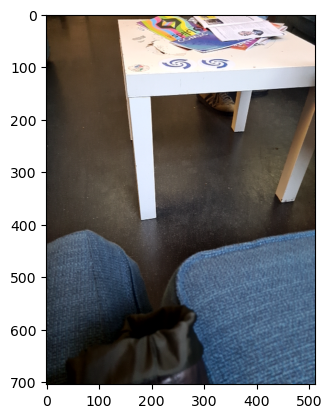

In [18]:
plt.imshow(rgb_image_resized)

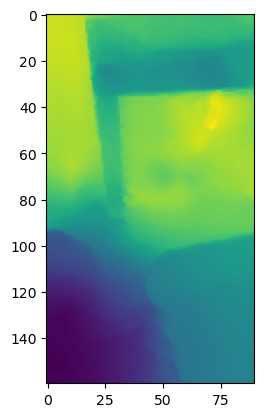

In [22]:
plt.imshow(depthMap)

In [12]:
depthMap.shape

(160, 90)

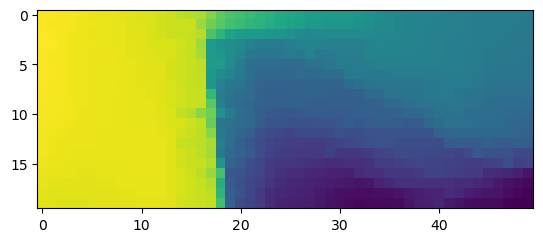

In [27]:
a = depthMap[140:,0:50]
b = depthMap[:20,0:50]

plt.imshow(b)

In [29]:
a

array([[0.302, 0.303, 0.304, 0.304, 0.305, 0.305, 0.306, 0.306, 0.308,
        0.309, 0.313, 0.314, 0.314, 0.315, 0.316, 0.322, 0.326, 0.327,
        0.331, 0.335, 0.337, 0.34 , 0.342, 0.346, 0.349, 0.353, 0.356,
        0.362, 0.364, 0.365, 0.368, 0.371, 0.373, 0.38 , 0.382, 0.386,
        0.391, 0.397, 0.405, 0.412, 0.412, 0.415, 0.429, 0.448, 0.463,
        0.473, 0.476, 0.497, 0.532, 0.538],
       [0.302, 0.302, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308,
        0.309, 0.311, 0.311, 0.313, 0.314, 0.318, 0.319, 0.321, 0.326,
        0.33 , 0.331, 0.331, 0.334, 0.34 , 0.343, 0.343, 0.349, 0.356,
        0.358, 0.358, 0.361, 0.365, 0.371, 0.372, 0.376, 0.383, 0.386,
        0.39 , 0.394, 0.4  , 0.411, 0.414, 0.416, 0.424, 0.452, 0.467,
        0.472, 0.482, 0.5  , 0.511, 0.523],
       [0.301, 0.301, 0.302, 0.303, 0.303, 0.304, 0.304, 0.305, 0.306,
        0.308, 0.31 , 0.312, 0.313, 0.315, 0.315, 0.317, 0.321, 0.326,
        0.327, 0.328, 0.328, 0.333, 0.338, 0.342, 0.343, 0.3

In [2]:
mesh_path = "server/user_data/processed_user_data/6113_mesh.obj"

bpa_mesh = o3d.io.read_triangle_mesh(mesh_path)

ms = pymeshlab.MeshSet()
ms.load_new_mesh(mesh_path)

In [3]:
o3d.visualization.draw_geometries([bpa_mesh])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [13]:
bpa_mesh = o3d.io.read_triangle_mesh(mesh_path)
T = np.eye(4)
T[0,0] = -1
T[2,2] = -1
print(T)
bpa_mesh.transform(T)
o3d.visualization.draw_geometries([bpa_mesh])

[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]


In [9]:
print(T)
mesh_t = bpa_mesh.transform(T)
o3d.visualization.draw_geometries([mesh_t])

[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
